Welcome to the EEA Summer School 2025!

Let's do some exercises.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

In [2]:
def Greens_free_field(x, y, x0, y0, f, c):
    """Compute the 2D Green's function in free field."""
    """
    Parameters:
    x, y : np.ndarray
        Receiver coordinates.
    x0, y0 : float
        Source coordinates.
    f : float
        Frequency.
    c : float
        Speed of sound.
    Returns:
    G : np.ndarray
        The computed Green's function at the specified coordinates.
    """
    r = np.sqrt((x - x0)**2 + (y - y0)**2)
    k = 2 * np.pi * f / c
    G = np.exp(-1j * k * r) / (4 * np.pi * r)
    return G

def Greens_room(x, y, x0, y0, Lx, Ly, Nx, Ny, f, tau, c):
    """Compute the 2D Green's function in a rectangular domain with rigid walls."""
    """
    Parameters:
    x, y : np.ndarray
        Receiver coordinates.
    x0, y0 : float
        Source coordinates.
    Lx, Ly : float
        Dimensions of the rectangular domain.
    Nx, Ny : int
        Number of modes in the x and y directions.
    f : float
        Frequency.
    tau : float
        Time constant (damping factor).
    c : float
        Speed of sound.
    Returns:
    G : np.ndarray
        The computed Green's function at the specified coordinates.
    """
    def mode_shapes(nx, ny, x, y):
        return np.cos(np.pi * nx * x / Lx) * np.cos(np.pi * ny * y / Ly)
    
    k = 2 * np.pi * f / c
    G = 0
    for nx in range(Nx):
        for ny in range(Ny):
            mode_xy = mode_shapes(nx, ny, x, y)
            mode_x0y0 = mode_shapes(nx, ny, x0, y0)
            k_n = np.sqrt((np.pi * nx / Lx)**2 + (np.pi * ny / Ly)**2)
            G += mode_xy * mode_x0y0 / (k**2 - k_n**2 - 1j*k / (tau * c))
    return -G/(Lx * Ly)



In [ ]:
# Define parameters
c = 343 
f = 89.3
Lx, Ly = 5.0, 3.0  
Nx, Ny = 10, 10 
x0, y0 = 0.1, 0.1
tau = 0.5

# Compute the Green's function on a grid
X, Y = np.meshgrid(np.linspace(0, Lx, int(Lx*100)), np.linspace(0, Ly, int(Ly*100)))
r_rec = np.array([X.flatten(), Y.flatten()]).T
p_ref = Greens_room(r_rec[:, 0], r_rec[:, 1], x0, y0, Lx, Ly, Nx, Ny, f, tau, c)

# Take samples randomly and add noise
np.random.seed(42)
m = 15
indices = np.random.choice(p_ref.size, m, replace=False)
p = p_ref[indices]
p += 0.1 * (np.random.randn(m) + 1j * np.random.randn(m)) * np.sqrt(np.mean(np.abs(p)**2))
r = r_rec[indices]

# Make a figure of the Green's function over space
plt.figure(figsize=(5, 3))
plt.contourf(X, Y, 20*np.log10(np.abs(p_ref)).reshape(X.shape), levels=50, cmap='viridis')
plt.scatter(r[:, 0], r[:, 1], c='red', s=10, label='Sampled Points')
plt.legend(loc='upper right')
plt.colorbar(label='Magnitude (dB)')
plt.title('2D Green\'s Function')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

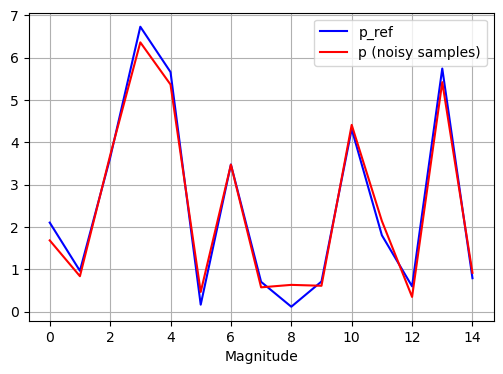

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(np.abs(p_ref[indices]), color='blue', label='p_ref')
plt.plot(np.abs(p), color='red', label='p (noisy samples)')
plt.xlabel('Magnitude')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Plane wave expansion
n = 360
theta = np.linspace(0, 2 * np.pi, n)
k  = (2 * np.pi * f / c) * np.array([np.cos(theta), np.sin(theta)]).T
A = np.exp(-1j * k @ r.T).T

In [ ]:
cond_A = np.linalg.cond(A)
print(f"Condition number of A: {cond_A:.2e}")

Condition number of A: 8.04e+05


In [ ]:
# Solve problem
alpha = 1

x_ls = cp.Variable(n, complex=True)
cost = cp.sum_squares(A @ x_ls - p)
prob = cp.Problem(cp.Minimize(cost))
prob.solve()

x_l2 = cp.Variable(n, complex=True)
cost = cp.sum_squares(A @ x_l2 - p) + alpha*cp.norm(x_l2, 2)
prob = cp.Problem(cp.Minimize(cost))
prob.solve()

x_l1 = cp.Variable(n, complex=True)
cost = cp.sum_squares(A @ x_l1 - p) + alpha*cp.norm(x_l1, 1)
prob = cp.Problem(cp.Minimize(cost))
prob.solve()

np.float64(8.005321428565704)

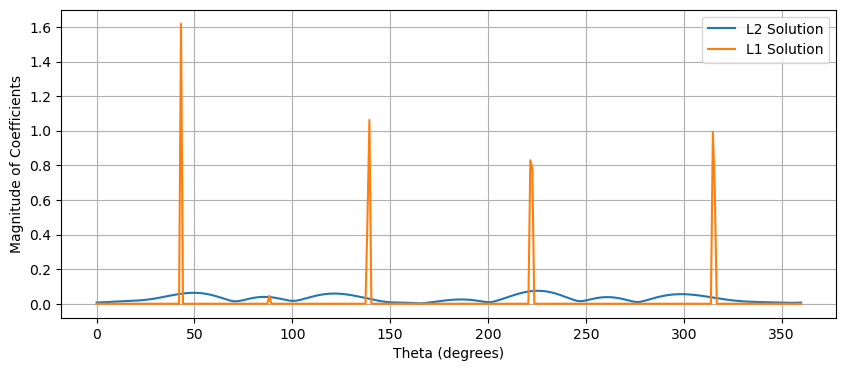

In [ ]:
plt.figure(figsize=(10, 4))
# plt.plot(theta * 180 / np.pi, np.abs(x_ls.value), label='LS Solution')
plt.plot(theta * 180 / np.pi, np.abs(x_l2.value), label='L2 Solution')
plt.plot(theta * 180 / np.pi, np.abs(x_l1.value), label='L1 Solution')
plt.xlabel('Theta (degrees)')
plt.ylabel('Magnitude of Coefficients')
plt.legend()
plt.grid()
plt.show()

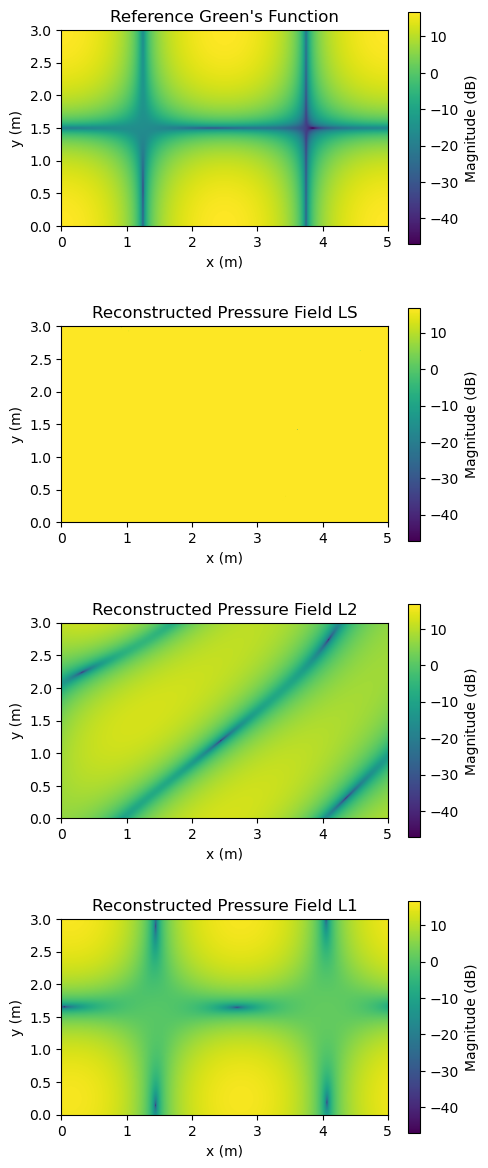

In [ ]:
r_rec = np.array([X.flatten(), Y.flatten()]).T
B = np.exp(1j * k @ r_rec.T).T

fig, axes = plt.subplots(4, 1, figsize=(5, 12))

# Compute the min and max values in dB for consistent colorbars
ref_db = 20 * np.log10(np.abs(p_ref))
rec_ls_db = 20 * np.log10(np.abs(p_rec_ls := B @ x_ls.value))
rec_l2_db = 20 * np.log10(np.abs(p_rec_l2 := B @ x_l2.value))
rec_l1_db = 20 * np.log10(np.abs(p_rec_l1 := B @ x_l1.value))
vmin, vmax = min(ref_db), max(ref_db)

# Reference Green's Function
im0 = axes[0].imshow(ref_db.reshape(X.shape), cmap='viridis', vmin=vmin, vmax=vmax, extent=(0, Lx, 0, Ly))
axes[0].set_title("Reference Green's Function")
axes[0].set_xlabel('x (m)')
axes[0].set_ylabel('y (m)')
fig.colorbar(im0, ax=axes[0], label='Magnitude (dB)')

# Reconstructed Pressure Field LS
im1 = axes[1].imshow(rec_ls_db.reshape(X.shape), cmap='viridis', vmin=vmin, vmax=vmax, extent=(0, Lx, 0, Ly))
axes[1].set_title('Reconstructed Pressure Field LS')
axes[1].set_xlabel('x (m)')
axes[1].set_ylabel('y (m)')
fig.colorbar(im1, ax=axes[1], label='Magnitude (dB)')

# Reconstructed Pressure Field L2
im2 = axes[2].imshow(rec_l2_db.reshape(X.shape), cmap='viridis', vmin=vmin, vmax=vmax, extent=(0, Lx, 0, Ly))
axes[2].set_title('Reconstructed Pressure Field L2')
axes[2].set_xlabel('x (m)')
axes[2].set_ylabel('y (m)')
fig.colorbar(im2, ax=axes[2], label='Magnitude (dB)')

# Reconstructed Pressure Field L1
im3 = axes[3].imshow(rec_l1_db.reshape(X.shape), cmap='viridis', vmin=vmin, vmax=vmax, extent=(0, Lx, 0, Ly))
axes[3].set_title('Reconstructed Pressure Field L1')
axes[3].set_xlabel('x (m)')
axes[3].set_ylabel('y (m)')
fig.colorbar(im3, ax=axes[3], label='Magnitude (dB)')

plt.tight_layout()
plt.show()


In [ ]:
# Define parameters
c = 343 
f = 89.3
Lx, Ly = 5.0, 3.0  
Nx, Ny = 10, 10 
x0, y0 = 0.1, 0.1
tau = 0.5

# Compute the Green's function on a grid
X, Y = np.meshgrid(np.linspace(0, Lx, int(Lx*100)), np.linspace(0, Ly, int(Ly*100)))
r_rec = np.array([X.flatten(), Y.flatten()]).T
p_ref = Greens_free_field(r_rec[:, 0], r_rec[:, 1], x0, y0, f, c)

# Take samples randomly and add noise
np.random.seed(42)
m = 15
indices = np.random.choice(p_ref.size, m, replace=False)
p = p_ref[indices]
p += 0.1 * (np.random.randn(m) + 1j * np.random.randn(m)) * np.sqrt(np.mean(np.abs(p)**2))
r = r_rec[indices]

# Make a figure of the Green's function over space
plt.figure(figsize=(5, 3))
plt.contourf(X, Y, 20*np.log10(np.abs(p_ref)).reshape(X.shape), levels=50, cmap='viridis')
plt.scatter(r[:, 0], r[:, 1], c='red', s=10, label='Sampled Points')
plt.legend(loc='upper right')
plt.colorbar(label='Magnitude (dB)')
plt.title('2D Green\'s Function')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

NameError: name 'Greens_freefield' is not defined